# Optimized PyTorch CNN with Optuna

In this notebook, we optimize a convolutional neural network (CNN) for the CIFAR-10 dataset using Optuna for hyperparameter tuning.

## Notebook set-up

### Imports

In [1]:
# Standard library imports
import pickle
from pathlib import Path

# Third party imports
import matplotlib.pyplot as plt
import numpy as np
import optuna
import torch
import torch.optim as optim
from torchvision import datasets, transforms

# Package imports
from image_classification_tools.pytorch.data import (
    load_dataset, prepare_splits, create_dataloaders
)
from image_classification_tools.pytorch.evaluation import evaluate_model
from image_classification_tools.pytorch.hyperparameter_optimization import create_cnn, create_objective
from image_classification_tools.pytorch.plotting import (
    plot_sample_images, plot_learning_curves, 
    plot_confusion_matrix, plot_class_probability_distributions,
    plot_evaluation_curves, plot_optimization_results
)
from image_classification_tools.pytorch.training import train_model

### Configuration

In [2]:
# Set random seeds for reproducibility
torch.manual_seed(315)
np.random.seed(315)

# Check for GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Suppress Optuna info messages (show only warnings and errors)
optuna.logging.set_verbosity(optuna.logging.WARNING)

# SQLite storage for Optuna (local file)
data_dir = Path('../data/pytorch')
data_dir.mkdir(parents=True, exist_ok=True)
storage_path = data_dir / 'cnn_optimization.db'
storage_url = f'sqlite:///{storage_path}'

# CIFAR-10 class names in class order
class_names = [
    'airplane', 'automobile', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'
]

num_classes = len(class_names)

Using device: cuda


### Fixed hyperparameters

In [3]:
# Optuna settings
run_optimization = False # Run optimization (True) or load results from disk for evaluation (False)
start_new_study = False  # Clear results and start new study (True) or resume previous run (False) 
validation_size = 10000
n_trials = 200           # Number of optimization trials
n_epochs_per_trial = 100 # Epochs per trial
n_epochs_final = 25      # Epochs for final model training with optimized hyperparameters
print_every = 10         # Print training progress every n epochs

## 1. Visualize CIFAR-10 sample images

CIFAR-10 contains 32x32 color images (3 channels) across 10 classes.

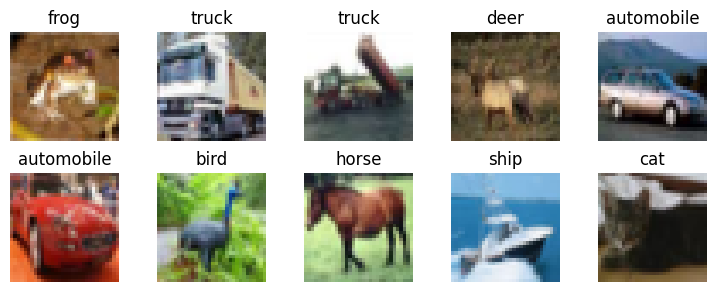

In [4]:
# Make sure data directory exists
data_dir = Path('../data/pytorch/cifar10')
data_dir.mkdir(parents=True, exist_ok=True)

# Define transform (RGB)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

# Get a sample dataset for visualization
sample_dataset = datasets.CIFAR10(
    root=data_dir,
    train=True,
    transform=transform
)

# Plot first 10 images from the training dataset
fig, axes = plot_sample_images(sample_dataset, class_names)
plt.show()

## 2. Optuna hyperparameter optimization

We use `create_objective()` to generate an objective function that Optuna will optimize.
The function samples hyperparameters, creates and trains a model, and returns validation accuracy.

### 2.1. Define hyperparameter search space

In [5]:
# Define hyperparameter search space
search_space = {
    'batch_size': [64, 128, 256, 512],
    'n_conv_blocks': (1, 8),               # Number of conv blocks
    'initial_filters': [16, 32, 64, 128],  # Filters in first block (doubles each block)
    'n_fc_layers': (1, 5),                 # Number of FC layers in classifier
    'conv_dropout_rate': (0.1, 0.5),       # Conv block dropout
    'fc_dropout_rate': (0.3, 0.7),         # FC layer dropout
    'learning_rate': (1e-5, 1e-2, 'log'),
    'optimizer': ['Adam', 'SGD', 'RMSprop'],
    'sgd_momentum': (0.8, 0.99),           # Used when optimizer='SGD'
    'weight_decay': (1e-6, 1e-3, 'log')
}

print('Hyperparameter search space:')

for key, value in search_space.items():
    print(f'  {key}: {value}')

Hyperparameter search space:
  batch_size: [64, 128, 256, 512]
  n_conv_blocks: (1, 8)
  initial_filters: [16, 32, 64, 128]
  n_fc_layers: (1, 5)
  conv_dropout_rate: (0.1, 0.5)
  fc_dropout_rate: (0.3, 0.7)
  learning_rate: (1e-05, 0.01, 'log')
  optimizer: ['Adam', 'SGD', 'RMSprop']
  sgd_momentum: (0.8, 0.99)
  weight_decay: (1e-06, 0.001, 'log')


### 2.2. Create objective function

In [6]:
# Create objective function for Optuna
objective = create_objective(
    data_dir=data_dir,
    transform=transform,
    n_epochs=n_epochs_per_trial,
    device=device,
    num_classes=num_classes,
    search_space=search_space
)

### 2.3. Run optimization

In [7]:
%%time

if run_optimization:
    print('Running hyperparameter optimization...')

    # Delete existing study if desired & it exists
    if start_new_study == True:

        print('Starting new study')
        try:
            optuna.delete_study(study_name='cnn_optimization', storage=storage_url)
            print('Deleted existing study')

        except KeyError:
            print('No existing study found')

    else:
        if storage_path.exists():
            print(f'Resuming study {storage_path}')

        else:
            print(f'No prior results found at {storage_path}, starting new study')

    # Create Optuna study with SQLite storage (maximize validation accuracy)
    study = optuna.create_study(
        direction='maximize',
        study_name='cnn_optimization',
        storage=storage_url,
        load_if_exists=True,  # Resume if study already exists
        pruner=None #optuna.pruners.MedianPruner(n_warmup_steps=5)
    )

    print(f'Study stored at: {storage_path}')

    # Run optimization
    study.optimize(objective, n_trials=n_trials, show_progress_bar=True)

else:

    # Load results from disk
    study = optuna.load_study(
        study_name='cnn_optimization',
        storage=storage_url
    )

    print(f'Study loaded from: {storage_path}')

print(f'\nBest validation accuracy: {study.best_trial.value:.2f}%')

for key, value in study.best_trial.params.items():
    print(f' - {key}: {value}')

print()

Study loaded from: ../data/pytorch/cnn_optimization.db

Best validation accuracy: 87.22%
 - batch_size: 128
 - n_conv_blocks: 5
 - initial_filters: 32
 - n_fc_layers: 3
 - conv_dropout_rate: 0.17380147046267944
 - fc_dropout_rate: 0.4250817601248304
 - learning_rate: 0.005391936260639258
 - optimizer: SGD
 - weight_decay: 5.397268412529651e-05
 - sgd_momentum: 0.8283619030362693

CPU times: user 715 ms, sys: 41.1 ms, total: 756 ms
Wall time: 755 ms


### 2.4. Visualize optimization results

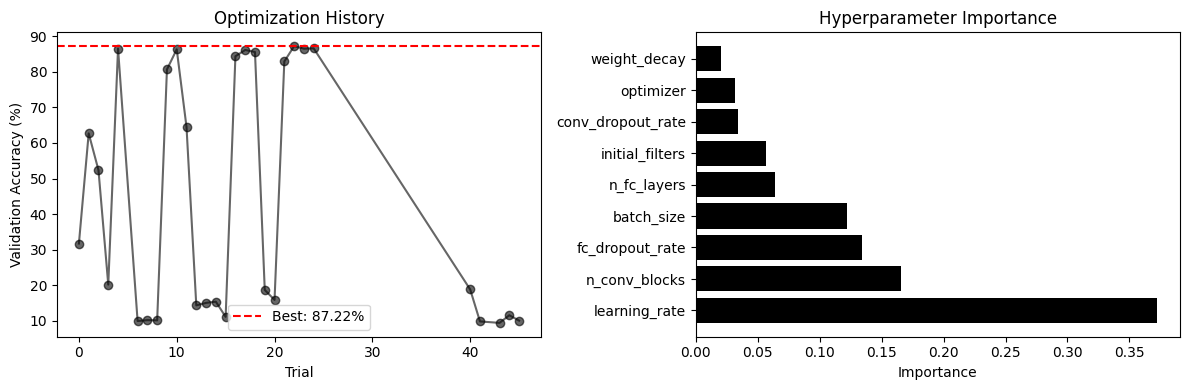

In [8]:
fig, axes = plot_optimization_results(study)
plt.show()

## 3. Train final model with best hyperparameters

### 3.1. Create optimized model

In [9]:
# Extract best hyperparameters
best_params = study.best_trial.params

print('Best hyperparameters:')
for key, value in best_params.items():
    print(f'  {key}: {value}')

# Recreate data loaders with best batch size
best_batch_size = best_params['batch_size']

# Load datasets
train_dataset = load_dataset(
    data_source=datasets.CIFAR10,
    transform=transform,
    root=data_dir,
    train=True
)

test_dataset = load_dataset(
    data_source=datasets.CIFAR10,
    transform=transform,
    root=data_dir,
    train=False
)

# Prepare splits
train_dataset, val_dataset, test_dataset = prepare_splits(
    train_dataset=train_dataset,
    test_dataset=test_dataset,
    val_size=validation_size
)

# Create dataloaders
train_loader, val_loader, test_loader = create_dataloaders(
    train_dataset, val_dataset, test_dataset,
    batch_size=best_batch_size,
    preload_to_memory=True,
    device=device
)

print(f'\nRecreated data loaders with batch size: {best_batch_size}')

# Create model with best hyperparameters
best_model = create_cnn(
    n_conv_blocks=best_params['n_conv_blocks'],
    initial_filters=best_params['initial_filters'],
    n_fc_layers=best_params['n_fc_layers'],
    conv_dropout_rate=best_params['conv_dropout_rate'],
    fc_dropout_rate=best_params['fc_dropout_rate'],
    num_classes=num_classes,
    in_channels=3
).to(device)

# Create optimizer with best hyperparameters
if best_params['optimizer'] == 'Adam':
    best_optimizer = optim.Adam(
        best_model.parameters(), 
        lr=best_params['learning_rate'],
        weight_decay=best_params['weight_decay']
    )

elif best_params['optimizer'] == 'SGD':
    best_optimizer = optim.SGD(
        best_model.parameters(), 
        lr=best_params['learning_rate'],
        momentum=best_params.get('sgd_momentum', 0.9),
        weight_decay=best_params['weight_decay']
    )

else:  # RMSprop
    best_optimizer = optim.RMSprop(
        best_model.parameters(), 
        lr=best_params['learning_rate'],
        weight_decay=best_params['weight_decay']
    )

# Set cross-entropy loss
criterion = torch.nn.CrossEntropyLoss()

# Get total trainable parameters
trainable_params = sum(p.numel() for p in best_model.parameters() if p.requires_grad)

print(f'\n{best_model}')
print(f'\nTotal parameters: {trainable_params:,}')

Best hyperparameters:
  batch_size: 128
  n_conv_blocks: 5
  initial_filters: 32
  n_fc_layers: 3
  conv_dropout_rate: 0.17380147046267944
  fc_dropout_rate: 0.4250817601248304
  learning_rate: 0.005391936260639258
  optimizer: SGD
  weight_decay: 5.397268412529651e-05
  sgd_momentum: 0.8283619030362693



Recreated data loaders with batch size: 128

Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (7): Dropout(p=0.17380147046267944, inplace=False)
  (8): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): ReLU()
  (11): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (12): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (13): ReLU()
  (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (15): Dropout(p=0.17380

### 3.2. Train optimized model

In [10]:
%%time

history = train_model(
    model=best_model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=best_optimizer,
    device=device,
    lazy_loading=False,  # Data already on GPU from make_data_loaders
    epochs=n_epochs_final,
    print_every=print_every
)

print()

Epoch   1/25 - loss: 2.1672 - acc: 16.84% - val_loss: 2.0467 - val_acc: 23.39%
Epoch  10/25 - loss: 0.8680 - acc: 71.42% - val_loss: 0.8472 - val_acc: 71.33%
Epoch  20/25 - loss: 0.5533 - acc: 82.65% - val_loss: 0.6106 - val_acc: 80.74%

CPU times: user 3min 9s, sys: 427 ms, total: 3min 9s
Wall time: 3min 8s


### 3.3. Learning curves

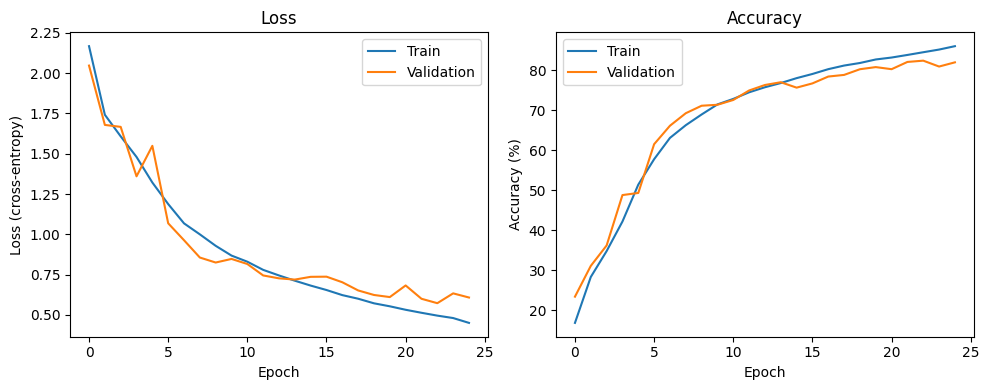

In [11]:
fig, axes = plot_learning_curves(history)
plt.show()

## 4. Evaluate optimized model on test set

### 4.1. Calculate test accuracy

In [12]:
test_accuracy, predictions, true_labels = evaluate_model(best_model, test_loader)
print(f'Test accuracy: {test_accuracy:.2f}%')

Test accuracy: 82.08%


### 4.2. Per-class accuracy

In [13]:
# Calculate per-class accuracy
class_correct = {name: 0 for name in class_names}
class_total = {name: 0 for name in class_names}

for pred, true in zip(predictions, true_labels):

    class_name = class_names[true]
    class_total[class_name] += 1

    if pred == true:
        class_correct[class_name] += 1

print('Per-class accuracy:')
print('-' * 30)

for name in class_names:
    acc = 100 * class_correct[name] / class_total[name]
    print(f'{name:12s}: {acc:.2f}%')

Per-class accuracy:
------------------------------
airplane    : 84.00%
automobile  : 92.80%
bird        : 71.10%
cat         : 68.50%
deer        : 81.70%
dog         : 64.40%
frog        : 85.90%
horse       : 89.70%
ship        : 95.80%
truck       : 86.90%


### 4.3. Confusion matrix

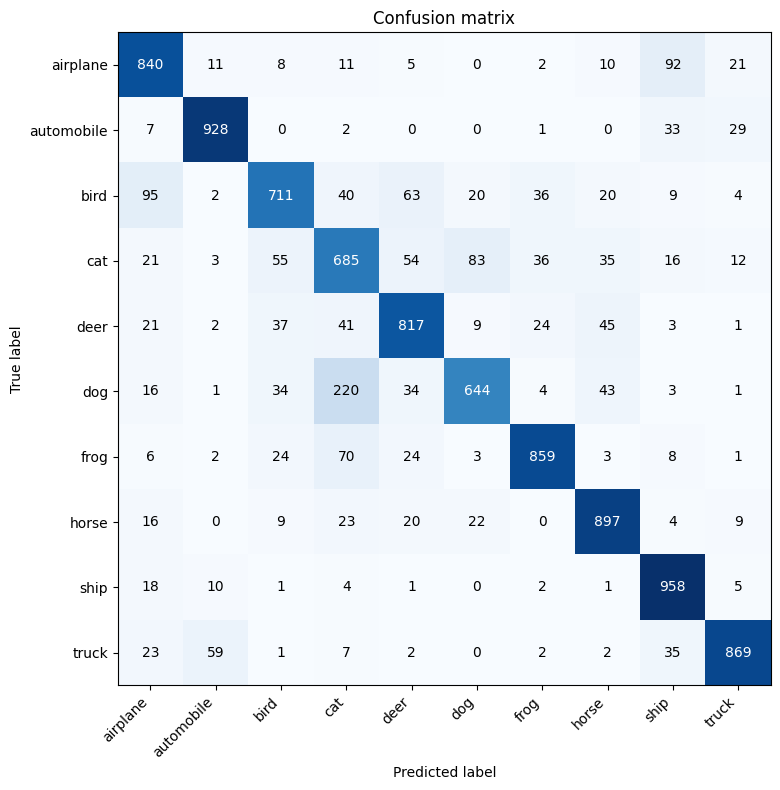

In [14]:
fig, ax = plot_confusion_matrix(true_labels, predictions, class_names)
plt.show()

### 4.4. Predicted class probability distributions

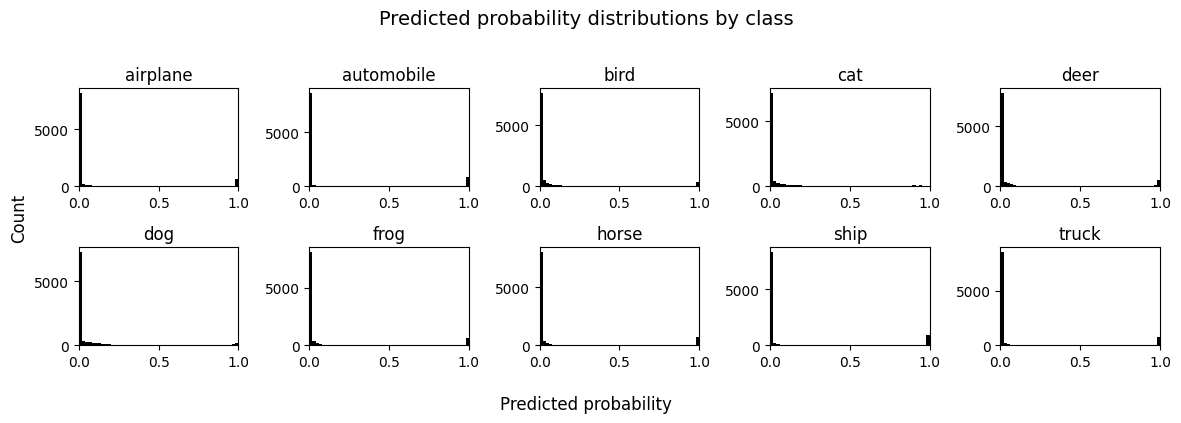

In [15]:
# Get predicted probabilities for all test samples
best_model.eval()
all_probs = []

with torch.no_grad():
    for images, _ in test_loader:
        outputs = best_model(images)
        probs = torch.softmax(outputs, dim=1)
        all_probs.append(probs.cpu().numpy())

all_probs = np.concatenate(all_probs, axis=0)

# Plot probability distributions
fig, axes = plot_class_probability_distributions(all_probs, class_names)
plt.show()

### 4.5. Evaluation curves

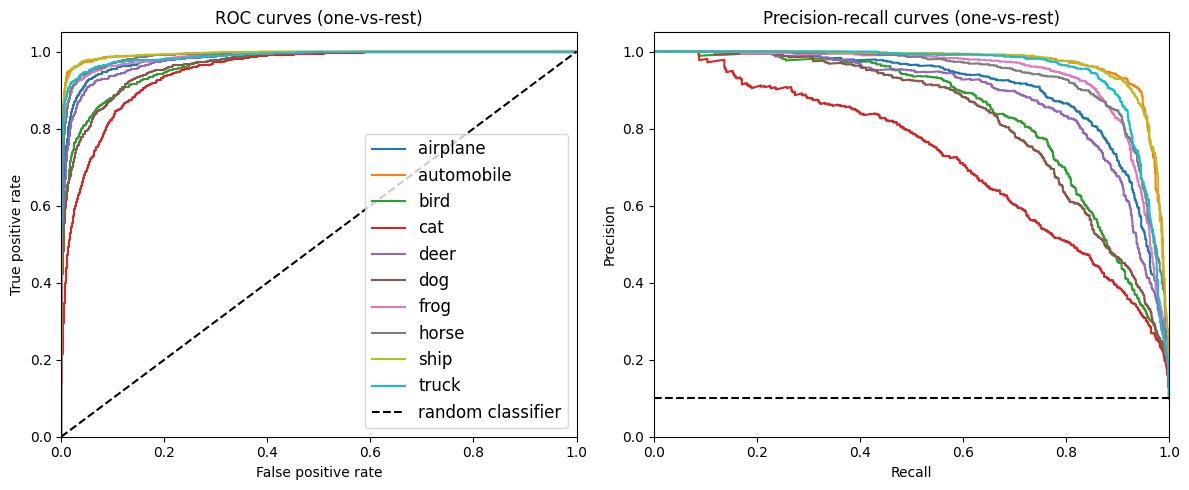

In [16]:
fig, (ax1, ax2) = plot_evaluation_curves(true_labels, all_probs, class_names)
plt.show()

## 5. Save optimized model and hyperparameters

In [17]:
# Create models directory if it doesn't exist
models_dir = Path('../models/pytorch')
models_dir.mkdir(parents=True, exist_ok=True)

# Save model state dict
model_path = models_dir / 'optimized_cnn.pth'

torch.save({
    'model_state_dict': best_model.state_dict(),
    'optimizer_state_dict': best_optimizer.state_dict(),
    'best_params': best_params,
    'test_accuracy': test_accuracy,
    'history': history
}, model_path)

print(f'Model saved to: {model_path}')
print(f'Test accuracy: {test_accuracy:.2f}%')

Model saved to: ../models/pytorch/optimized_cnn.pth
Test accuracy: 82.08%


## 6. Save test results for comparison

In [18]:
# Create results directory
models_dir = Path('../data/pytorch/performance_results')
models_dir.mkdir(parents=True, exist_ok=True)
results_path = models_dir / 'optimized_cnn_results.pkl'

# Count model parameters
total_params = sum(p.numel() for p in best_model.parameters())
trainable_params = sum(p.numel() for p in best_model.parameters() if p.requires_grad)

# Create results dictionary
results_dict = {
    'true_labels': true_labels,
    'predictions': predictions,
    'all_probs': all_probs,
    'test_accuracy': test_accuracy,
    'total_params': total_params,
    'trainable_params': trainable_params
}

# Save results
with open(results_path, 'wb') as f:
    pickle.dump(results_dict, f)

print(f'Test results saved to: {results_path}')
print(f'  - Test accuracy: {test_accuracy:.2f}%')
print(f'  - Total parameters: {total_params:,}')
print(f'  - Trainable parameters: {trainable_params:,}')

Test results saved to: ../data/pytorch/performance_results/optimized_cnn_results.pkl
  - Test accuracy: 82.08%
  - Total parameters: 4,889,322
  - Trainable parameters: 4,889,322
